# Optimization of Features for Movie Rating Prediction

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from numpy import median
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


from pylab import rcParams

import statistics

%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

E:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data Processing

###  Change Format from json file

In [5]:
### converting the TMDB dataset that data into a format
### that will work best with scripts bulit on the IMDB dataset


def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df


def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [6]:
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'
                ]
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users',
                                         }

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}


def safe_access(container, index_values):
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan


def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])


def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])


def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['companies_1'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['companies_2'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['companies_3'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

### Load Datasets

In [107]:
movies = load_tmdb_movies("tmdb_5000_movies.csv")
credits = load_tmdb_credits("tmdb_5000_credits.csv")
data =convert_to_original_format(movies, credits)

In [8]:
data.head()

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,...,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name,companies_1,companies_2,companies_3
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,11800,2009.0,United States of America,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver,Ingenious Film Partners,Twentieth Century Fox Film Corporation,Dune Entertainment
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,4500,2007.0,United States of America,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley,Walt Disney Pictures,Jerry Bruckheimer Films,Second Mate Productions
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,4466,2015.0,United Kingdom,Sam Mendes,Daniel Craig,Christoph Waltz,Léa Seydoux,Columbia Pictures,Danjaq,B24
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...",...,9106,2012.0,United States of America,Christopher Nolan,Christian Bale,Michael Caine,Gary Oldman,Legendary Pictures,Warner Bros.,DC Entertainment
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,2124,2012.0,United States of America,Andrew Stanton,Taylor Kitsch,Lynn Collins,Samantha Morton,Walt Disney Pictures,NaN,NaN


In [109]:
data['plot_keywords'].head(10)

0    culture clash|future|space war|space colony|so...
1    ocean|drug abuse|exotic island|east india trad...
2    spy|based on novel|secret agent|sequel|mi6|bri...
3    dc comics|crime fighter|terrorist|secret ident...
4    based on novel|mars|medallion|space travel|pri...
5    dual identity|amnesia|sandstorm|love of one's ...
6    hostage|magic|horse|fairy tale|musical|princes...
7    marvel comic|sequel|superhero|based on comic b...
8    witch|magic|broom|school of witchcraft|wizardr...
9    dc comics|vigilante|superhero|based on comic b...
Name: plot_keywords, dtype: object

In [9]:
data['num_voted_users'].head()

0    11800
1     4500
2     4466
3     9106
4     2124
Name: num_voted_users, dtype: int64

In [10]:
### check for missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
homepage,3091,0.643556
companies_3,2479,0.516136
companies_2,1417,0.295024
tagline,844,0.175724
companies_1,351,0.073079


In [11]:
### 64% for homepage features are missing, we delete them
data.drop(['homepage'], axis=1, inplace=True)

In [12]:
### Delete rows contain 0 vote average
data = data[data['vote_average'] != 0]

In [13]:
### Delete rows contain 0 duration
data = data[data['duration'] != 0]

# Data Analysis

In [11]:
data.columns

Index(['budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'gross', 'duration',
       'spoken_languages', 'status', 'tagline', 'movie_title', 'vote_average',
       'num_voted_users', 'title_year', 'country', 'director_name',
       'actor_1_name', 'actor_2_name', 'actor_3_name', 'companies_1',
       'companies_2', 'companies_3'],
      dtype='object')

In [12]:
### Drop features that only know after movie release becauses we predict movie before it release.
data.drop(['num_voted_users','gross','popularity'], axis=1, inplace=True)

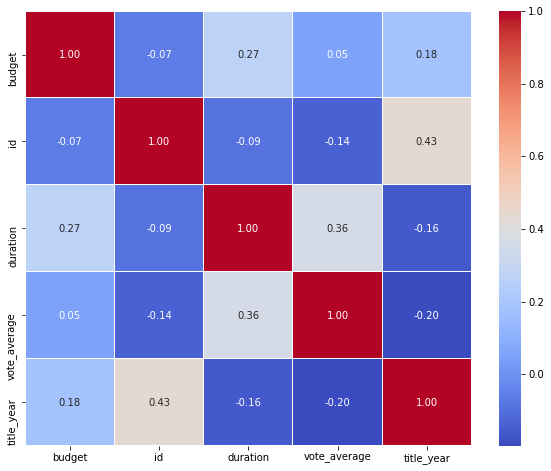

In [13]:
### Correlation matrix between numerical values
plt.figure(figsize = (10,8))
g = sns.heatmap(data[list(data)].corr(),annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

In [14]:
### We found that title_year and duration has an impact to vote_average score.

### Title_year

<Figure size 720x720 with 0 Axes>

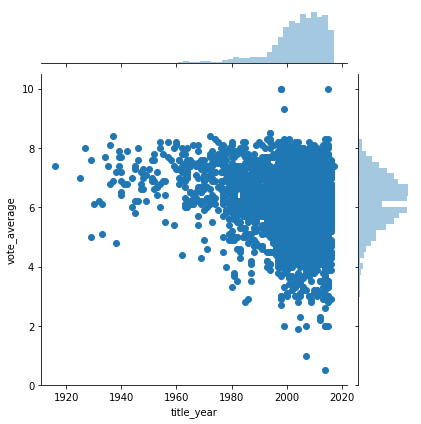

In [15]:
plt.figure(figsize = (10,10))
sns.jointplot(x="title_year", y="vote_average", data=data);

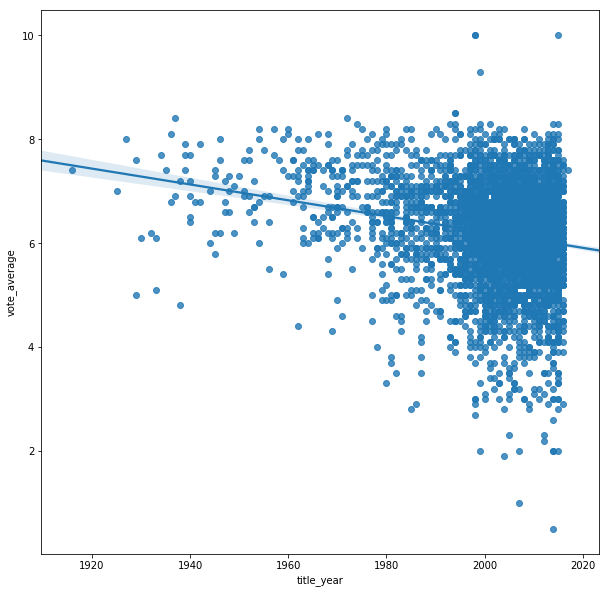

In [16]:
plt.figure(figsize = (10,10))
sns.regplot(x="title_year", y="vote_average", data=data);

### Duration

<Figure size 720x720 with 0 Axes>

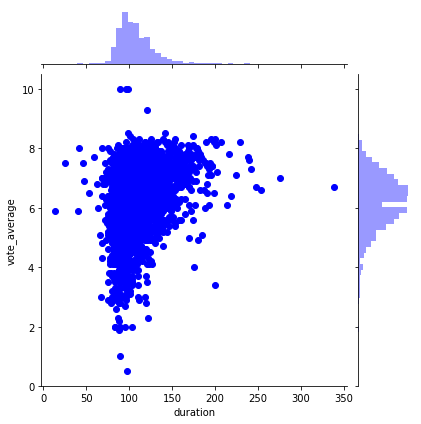

In [17]:
plt.figure(figsize = (10,10))
sns.jointplot(x="duration", y="vote_average", data=data, color= 'blue');

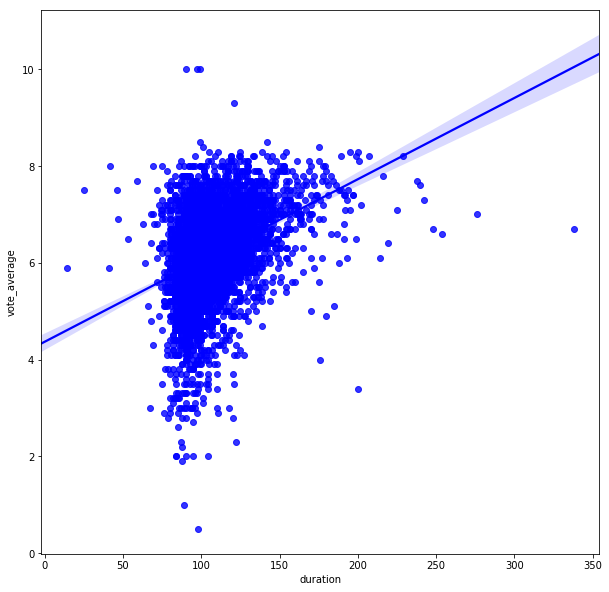

In [18]:
plt.figure(figsize = (10,10))
sns.regplot(x="duration", y="vote_average", data=data, color= 'Blue');

Decide a score to tell good or bad

Data classification
Declare good movies as a movie which got vote_score like  IMDB's weighted rating (wr)

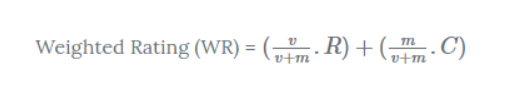

In [14]:
# v is the number of votes for the movie;
# m is the minimum votes required to be listed in the chart;
# R is the average rating of the movie; And
# C is the mean vote across the whole report

In [15]:
C= data['vote_average'].mean()
C

6.178418486326049

In [16]:
m= data['num_voted_users'].quantile(0.8)
m

976.4000000000005

In [17]:
q_movies = data.copy().loc[data['num_voted_users'] >= m]
q_movies.shape

(944, 28)

In [18]:
def weighted_rating(x, m=m, C=C):
    v = x['num_voted_users']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [19]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [20]:
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['id','original_title','vote_average', 'num_voted_users', 'score']].head(15)

,id,original_title,vote_average,num_voted_users,score
1881,278,The Shawshank Redemption,8.5,8205,8.253110
662,550,Fight Club,8.3,9413,8.100613
3337,238,The Godfather,8.4,5893,8.084230
3232,680,Pulp Fiction,8.3,8428,8.079729
65,155,The Dark Knight,8.2,12002,8.047911
809,13,Forrest Gump,8.2,7927,7.978301
96,27205,Inception,8.1,13752,7.972611
95,157336,Interstellar,8.1,10867,7.941580
1990,1891,The Empire Strikes Back,8.2,5879,7.912070
1818,424,Schindler's List,8.3,4329,7.909546


In [21]:
score = q_movies['score'].quantile(0.7)
score

6.867068860958262

In [22]:
data['Good'] = data['vote_average'].map(lambda s :1  if s >= score else 0)

In [23]:
data.loc[:, ['vote_average', 'Good']].head()

,vote_average,Good
0,7.2,1
1,6.9,1
2,6.3,0
3,7.6,1
4,6.1,0


In [24]:
rcParams['figure.figsize'] = 13,10

In [25]:
data['Good'].value_counts(sort = False)

0    3573
1    1144
Name: Good, dtype: int64

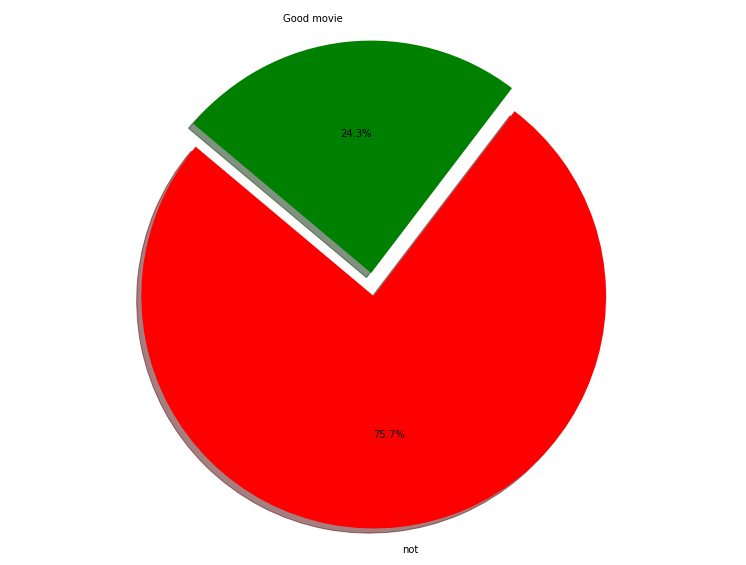

In [26]:
labels =["not","Good movie"]
sizes = data['Good'].value_counts(sort = False)
colors = ["red","green"]
explode = (0.1,0)
 
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140,)
plt.axis('equal')
plt.show()

In [27]:
#### 24.3% of movies in our dataset are good movie

# Budget

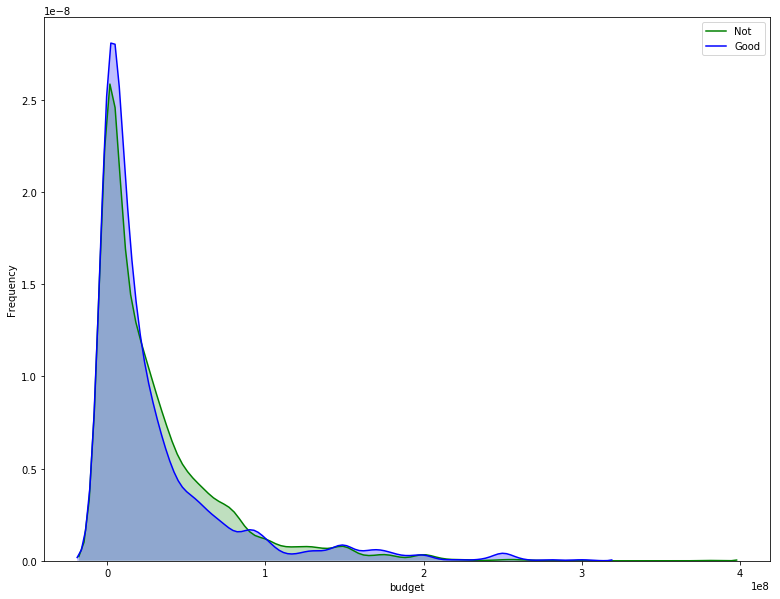

In [28]:
g = sns.kdeplot(data.budget[(data["Good"] == 0) ], color="green", shade = True)
g = sns.kdeplot(data.budget[(data["Good"] == 1) ], ax =g, color="Blue", shade= True)
g.set_xlabel("budget")
g.set_ylabel("Frequency")
g = g.legend(["Not","Good"])

In [29]:
sd = statistics.stdev(data.budget)
mean = data.budget.mean()
max = data.budget.max()
min = data.budget.min()

In [30]:
# Create new feature of budget 

data['VeryLowBud'] = data['budget'].map(lambda s: 1 if s < 10000000 else 0)
data['LowBud'] = data['budget'].map(lambda s: 1 if 10000000 <= s < mean else 0)
data['MedBud'] = data['budget'].map(lambda s: 1 if  mean <= s < mean+sd  else 0)
data['HighBud'] = data['budget'].map(lambda s: 1 if mean+sd <= s < 100000000 else 0)
data['VeryHighBud'] = data['budget'].map(lambda s: 1 if s >= 100000000 else 0)

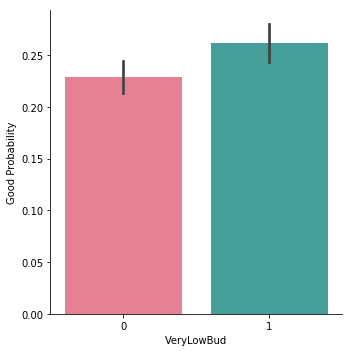

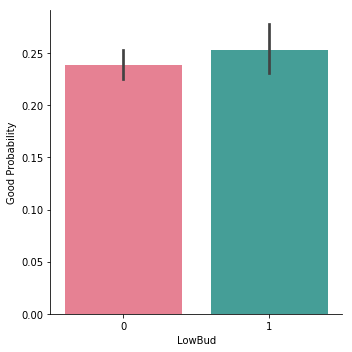

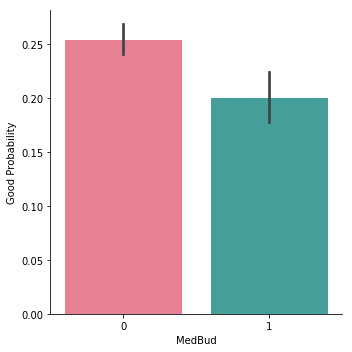

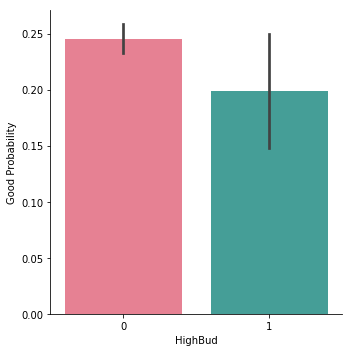

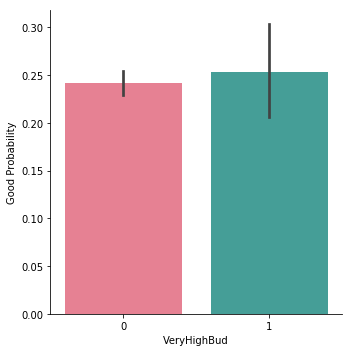

In [31]:
g = sns.factorplot(x="VeryLowBud",y="Good",data=data,kind="bar",palette = "husl")
g = g.set_ylabels("Good Probability")
g = sns.factorplot(x="LowBud",y="Good",data=data,kind="bar",palette = "husl")
g = g.set_ylabels("Good Probability")
g = sns.factorplot(x="MedBud",y="Good",data=data,kind="bar",palette = "husl")
g = g.set_ylabels("Good Probability")
g = sns.factorplot(x="HighBud",y="Good",data=data,kind="bar",palette = "husl")
g = g.set_ylabels("Good Probability")
g = sns.factorplot(x="VeryHighBud",y="Good",data=data,kind="bar",palette = "husl")
g = g.set_ylabels("Good Probability")

### Title_year

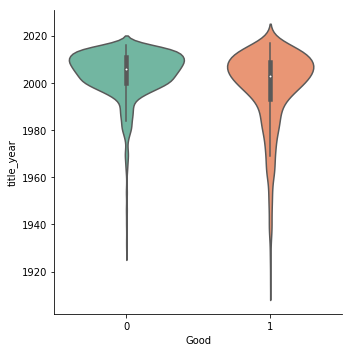

In [32]:
g = sns.factorplot(y="title_year",x="Good",data=data,kind="violin", palette = "Set2")

### Duration

In [33]:
data = data[np.isfinite(data['duration'])]

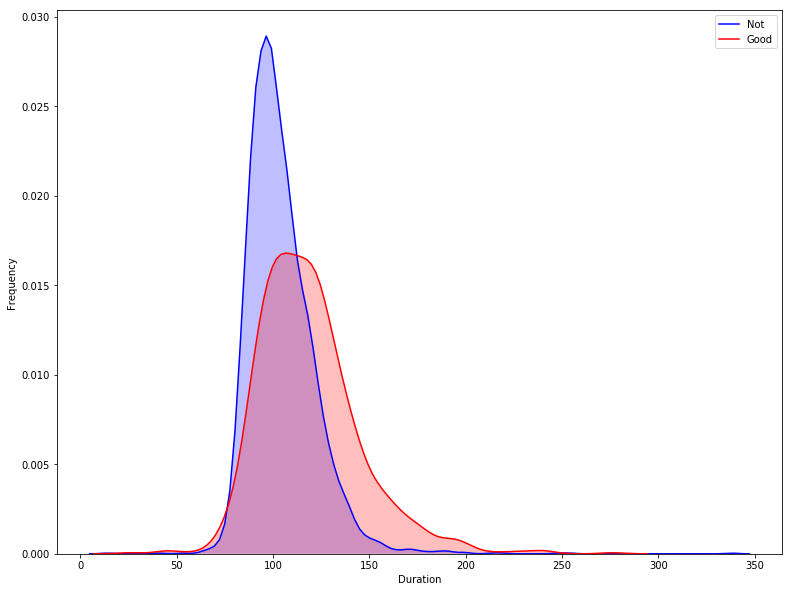

In [34]:
# duration distibution 
g = sns.kdeplot(data.duration[(data["Good"] == 0) ], color="blue", shade = True)
g = sns.kdeplot(data.duration[(data["Good"] == 1) ], ax =g, color="red", shade= True)
g.set_xlabel("Duration")
g.set_ylabel("Frequency")
g = g.legend(["Not","Good"])

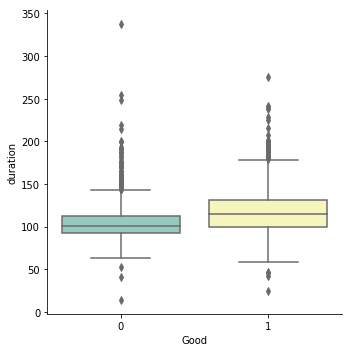

In [35]:
g = sns.factorplot(x="Good", y = "duration",data = data, kind="box", palette = "Set3")

In [36]:
### Create new feature of duration

data['ShortMovie'] = data['duration'].map(lambda s: 1 if s < 90 else 0)
data['NotTooLongMovie'] = data['duration'].map(lambda s: 1 if 90 <= s < 120 else 0)
data['LongMovie'] = data['duration'].map(lambda s: 1 if   s >= 120  else 0)

### Genres

In [37]:
data['genres'].head()

0    Action|Adventure|Fantasy|Science Fiction
1                    Adventure|Fantasy|Action
2                      Action|Adventure|Crime
3                 Action|Crime|Drama|Thriller
4            Action|Adventure|Science Fiction
Name: genres, dtype: object

In [38]:
def Obtain_list_Occurences(columnName):
    list_details = list(map(str,(data[columnName])))
    listOcc = []
    for i in data[columnName]:
        split_genre = list(map(str, i.split('|')))
        for j in split_genre:
            if j not in listOcc:
                listOcc.append(j)
    return listOcc

In [39]:
genre = []
genre = Obtain_list_Occurences("genres")

In [40]:
for word in genre:
    data[word] = data['genres'].map(lambda s: 1 if word in str(s) else 0)

### Keywords

In [41]:
data['plot_keywords'].head(20)

0     culture clash|future|space war|space colony|so...
1     ocean|drug abuse|exotic island|east india trad...
2     spy|based on novel|secret agent|sequel|mi6|bri...
3     dc comics|crime fighter|terrorist|secret ident...
4     based on novel|mars|medallion|space travel|pri...
5     dual identity|amnesia|sandstorm|love of one's ...
6     hostage|magic|horse|fairy tale|musical|princes...
7     marvel comic|sequel|superhero|based on comic b...
8     witch|magic|broom|school of witchcraft|wizardr...
9     dc comics|vigilante|superhero|based on comic b...
10    saving the world|dc comics|invulnerability|seq...
11    killing|undercover|secret agent|british secret...
12    witch|fortune teller|bondage|exotic island|mon...
13    texas|horse|survivor|texas ranger|partner|outl...
14    saving the world|dc comics|superhero|based on ...
15    based on novel|fictional place|brother sister ...
16    new york|shield|marvel comic|superhero|based o...
17    sea|captain|mutiny|sword|prime minister|sa

In [42]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [43]:
set_keywords = set()
for liste_keywords in data['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue
    set_keywords = set_keywords.union(liste_keywords)
set_keywords.remove('')

In [44]:
keyword_occurences, dum = count_word(data, 'plot_keywords', set_keywords)

In [45]:
### Funtion to find top 10 in list

def TopTen(theList):
    TopTen = list()

    for i in range(0, 10):
        TopTen.append(theList[i][0])
    
    return TopTen

In [46]:
from wordcloud import WordCloud

def makeCloud(Dict,name,color):
    words = dict()

    for s in Dict:
        words[s[0]] = s[1]

        wordcloud = WordCloud(
                      width=1500,
                      height=750, 
                      background_color=color, 
                      max_words=50,
                      max_font_size=500, 
                      normalize_plurals=False)
        wordcloud.generate_from_frequencies(words)


    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

In [47]:
for word in TopTen(keyword_occurences):
    data[word] = data['plot_keywords'].map(lambda s: 1 if word in str(s) else 0)

    
data.drop('plot_keywords',axis=1,inplace=True)

### Director

In [48]:
data['director_name'].fillna('unknown',inplace=True)

In [49]:
def to_frequency_table(data):
    frequencytable = {}
    for key in data:
        if key in frequencytable:
            frequencytable[key] += 1
        else:
            frequencytable[key] = 1
    return frequencytable

In [50]:
director_dic = to_frequency_table(data['director_name'])
director_list = list(director_dic.items())
director_list.sort(key=lambda tup: tup[1],reverse=True)

In [51]:
for word in TopTen(director_list):
    data[word] = data['director_name'].map(lambda s: 1 if word in str(s) else 0)

### Actor

In [52]:
data['actor_1_name'].fillna('unknown',inplace=True)
data['actor_2_name'].fillna('unknown',inplace=True)
data['actor_3_name'].fillna('unknown',inplace=True)

In [53]:
data[['actor_1_name','actor_2_name','actor_3_name']].head()

,actor_1_name,actor_2_name,actor_3_name
0,Sam Worthington,Zoe Saldana,Sigourney Weaver
1,Johnny Depp,Orlando Bloom,Keira Knightley
2,Daniel Craig,Christoph Waltz,Léa Seydoux
3,Christian Bale,Michael Caine,Gary Oldman
4,Taylor Kitsch,Lynn Collins,Samantha Morton


In [54]:
data['actors_name'] = data[['actor_1_name', 'actor_2_name','actor_3_name']].apply(lambda x: '|'.join(x), axis=1)

In [55]:
data[['actors_name']].head()

,actors_name
0,Sam Worthington|Zoe Saldana|Sigourney Weaver
1,Johnny Depp|Orlando Bloom|Keira Knightley
2,Daniel Craig|Christoph Waltz|Léa Seydoux
3,Christian Bale|Michael Caine|Gary Oldman
4,Taylor Kitsch|Lynn Collins|Samantha Morton


In [56]:
actor = []
actor = Obtain_list_Occurences("actors_name")

In [57]:
for word in actor:
    data[word] = data['actors_name'].map(lambda s: 1 if word in str(s) else 0)

### Company

In [58]:
data['companies_1'].fillna('unknown',inplace=True)
data['companies_2'].fillna('unknown',inplace=True)
data['companies_3'].fillna('unknown',inplace=True)

In [59]:
data['companies_name'] = data[['companies_1', 'companies_2','companies_3']].apply(lambda x: '|'.join(x), axis=1)
company = []
company = Obtain_list_Occurences("companies_name")

for word in company:
    data[word] = data['companies_name'].map(lambda s: 1 if word in str(s) else 0)

In [60]:
data.drop(['id','budget','original_title','overview','spoken_languages','production_companies','production_countries','release_date','status',
          'tagline','movie_title','vote_average','language','director_name','actor_1_name','actor_2_name','actor_3_name',
          'companies_1','companies_2','companies_3','country','genres','duration','actors_name','companies_name'], axis=1, inplace=True)

In [61]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
lucky crow films,0,0.0
Béla Dóra,0,0.0
Hideo Nakaizumi,0,0.0
Gao Yuanyuan,0,0.0
Nigel Bennett,0,0.0


# Modeling

In [62]:
data['is_train'] = np.random.uniform(0, 1, len(data)) <= .70

### View the top 5 rows
data.head()

,popularity,gross,num_voted_users,title_year,Good,VeryLowBud,LowBud,MedBud,HighBud,VeryHighBud,...,Camera Stylo Films,Daiei Studios,Iconoclast Films,Asylum Films,FM Entertainment,Eagle Eye Films Inc.,Front Street Pictures,rusty bear entertainment,lucky crow films,is_train
0,150.437577,2787965087,11800,2009.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,True
1,139.082615,961000000,4500,2007.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,True
2,107.376788,880674609,4466,2015.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,False
3,112.312950,1084939099,9106,2012.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,True
4,43.926995,284139100,2124,2012.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,False


In [63]:
### Split dataset to train dataset and test dataset
### 70% for training
### 30% for testing
train, test = data[data['is_train']==True], data[data['is_train']==False]

train.drop(['is_train'], axis=1, inplace=True)
test.drop(['is_train'], axis=1, inplace=True)

train["Good"] = train["Good"].astype(int)

Y_train = train["Good"]
X_train = train.drop(labels = ["Good"],axis = 1)
Y_test = test["Good"]
X_test = test.drop(labels = ["Good"],axis = 1)

In [64]:
print(len(train))

3317


In [65]:
print(len(test))

1399


## Model_1 Decision Tree

In [66]:
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Cross validation method

In [67]:
c_dec = cross_val_score(clf, X_train, Y_train, cv=10)
c_dec.mean()

0.7937770570045896

In [68]:
result = clf.predict_proba(X_test)[:]
test_result = np.asarray(Y_test)

In [69]:
Dec_result = pd.DataFrame(result[:,1])
Dec_result['Predict'] = Dec_result[0].map(lambda s: 1 if s >= 0.6  else 0)
Dec_result['testAnswer'] = pd.DataFrame(test_result)

Dec_result['Correct'] = np.where((Dec_result['Predict'] == Dec_result['testAnswer'])
                     , 1, 0)
Dec_result.head()

,0,Predict,testAnswer,Correct
0,1.0,1,0,0
1,0.0,0,0,1
2,0.0,0,0,1
3,0.0,0,0,1
4,0.0,0,0,1


In [70]:
### Test score
Dec_result['Correct'].mean()

0.7927090779127949

## Model_2 K-Nearest Neighbors

In [71]:
knn = KNeighborsClassifier(n_neighbors= 60 )
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=60, p=2,
           weights='uniform')

### Cross validation method

In [72]:
c_knn = cross_val_score(knn, X_train, Y_train, cv=10)
c_knn.mean()

0.7506947088317889

In [73]:
result = knn.predict_proba(X_test)[:]

In [74]:
knn_result = pd.DataFrame(result[:,1])
knn_result['Predict'] = knn_result[0].map(lambda s: 1 if s >= 0.6  else 0)
knn_result['testAnswer'] = pd.DataFrame(test_result)

knn_result['Correct'] = np.where((knn_result['Predict'] == knn_result['testAnswer'])
                     , 1, 0)
knn_result.head()

,0,Predict,testAnswer,Correct
0,0.483333,0,0,1
1,0.250000,0,0,1
2,0.516667,0,0,1
3,0.483333,0,0,1
4,0.483333,0,0,1


In [75]:
### Test Score
knn_result['Correct'].mean()

0.7626876340243031

## Model_3 Random Forest

In [76]:
Rfclf = RandomForestClassifier()
Rfclf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Cross validation method

In [77]:
c_rf =  cross_val_score(Rfclf, X_train, Y_train, cv=10)
c_rf.mean()

0.7841358001615345

In [78]:
result = Rfclf.predict_proba(X_test)[:]

In [79]:
Rf_result = pd.DataFrame(result[:,1])
Rf_result['Predict'] = Rf_result[0].map(lambda s: 1 if s >= 0.6  else 0)
Rf_result['testAnswer'] = pd.DataFrame(test_result)

Rf_result['Correct'] = np.where((Rf_result['Predict'] == Rf_result['testAnswer'])
                     , 1, 0)
Rf_result.head()

,0,Predict,testAnswer,Correct
0,0.7,1,0,0
1,0.1,0,0,1
2,0.2,0,0,1
3,0.3,0,0,1
4,0.2,0,0,1


### Test Score

In [80]:
Rf_result['Correct'].mean()

0.8020014295925662

## Model_4 Gradient Boosting

In [81]:
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Cross validation method

In [82]:
c_gb = cross_val_score(gb, X_train, Y_train, cv=10)
c_gb.mean()

0.8272481887485709

In [83]:
result = gb.predict_proba(X_test)[:]

In [84]:
gb_result = pd.DataFrame(result[:,1])
gb_result['Predict'] = gb_result[0].map(lambda s: 1 if s >= 0.6  else 0)
gb_result['testAnswer'] = pd.DataFrame(test_result)

gb_result['Correct'] = np.where((gb_result['Predict'] == gb_result['testAnswer'])
                     , 1, 0)
gb_result.head()

,0,Predict,testAnswer,Correct
0,0.797474,1,0,0
1,0.132388,0,0,1
2,0.404558,0,0,1
3,0.671199,1,0,0
4,0.188601,0,0,1


### Test Score

In [85]:
gb_result['Correct'].mean()

0.8205861329521087

# Conclusion of model performance

In [86]:
cv_means = []
cv_means.append(c_dec.mean())
cv_means.append(c_knn.mean())
cv_means.append(c_rf.mean())
cv_means.append(c_gb.mean())

In [87]:
cv_std = []
cv_std.append(c_dec.std())
cv_std.append(c_knn.std())
cv_std.append(c_rf.std())
cv_std.append(c_gb.std())

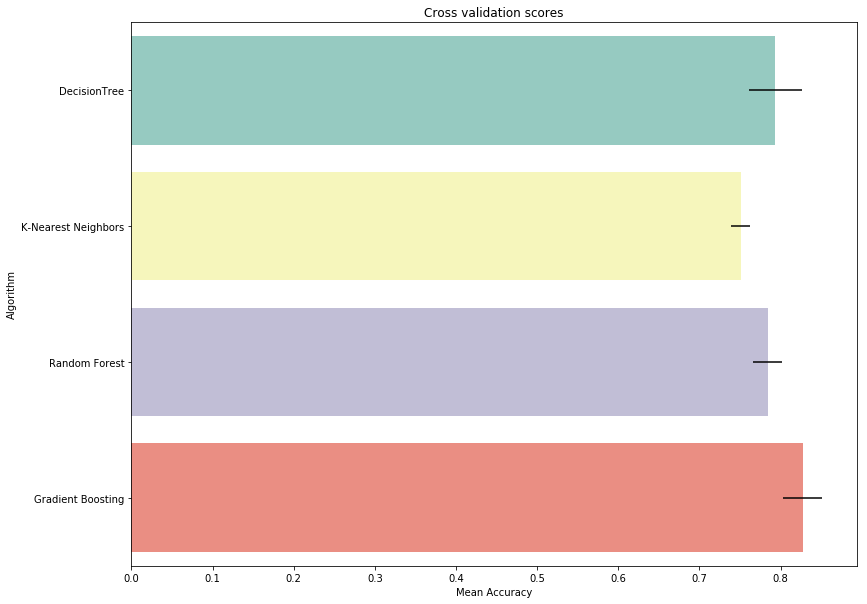

In [88]:
res1 = pd.DataFrame({"ACC":cv_means,"Std":cv_std,"Algorithm":["DecisionTree","K-Nearest Neighbors","Random Forest","Gradient Boosting"]})
res1["Type"]= "CrossValid"
g = sns.barplot("ACC","Algorithm",data = res1, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

# Test

In [89]:
tv_means = []
tv_means.append(Dec_result['Correct'].mean())
tv_means.append(knn_result['Correct'].mean())
tv_means.append(Rf_result['Correct'].mean())
tv_means.append(gb_result['Correct'].mean())

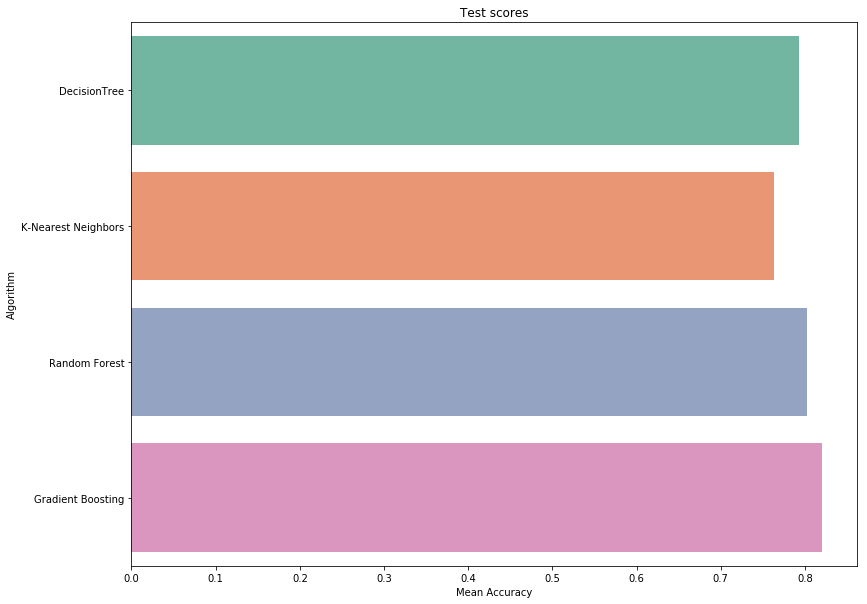

In [90]:
res2 = pd.DataFrame({"ACC":tv_means,"Algorithm":["DecisionTree","K-Nearest Neighbors","Random Forest","Gradient Boosting"]})
res2['Type'] = "Test";

g = sns.barplot("ACC","Algorithm",data = res2, palette="Set2",orient = "h")
g.set_xlabel("Mean Accuracy")
g = g.set_title("Test scores")

In [91]:
res = pd.concat([res1,res2])

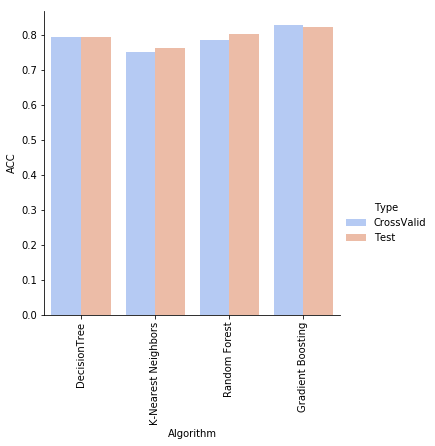

In [92]:
g = sns.factorplot(x='Algorithm', y='ACC', hue='Type',palette="coolwarm", data=res, kind='bar')
g.set_xticklabels(rotation=90)

# Weight in each feature

In [93]:
dec_fea = pd.DataFrame(clf.feature_importances_)
dec_fea["name"] = list(X_train) 
dec_fea.sort_values(by=0, ascending=False).head()

,0,name
2,0.176698,num_voted_users
3,0.124705,title_year
11,0.078043,LongMovie
1,0.062700,gross
0,0.058261,popularity


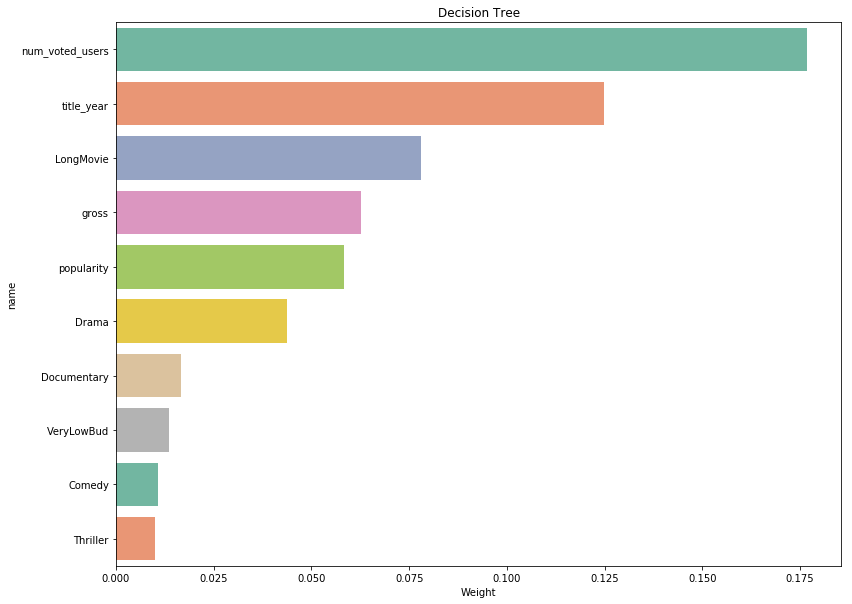

In [94]:
g = sns.barplot(0,"name",data = dec_fea.sort_values(by=0, ascending=False)[0:10], palette="Set2",orient = "h")
g.set_xlabel("Weight")
g = g.set_title("Decision Tree")

In [95]:
rf_fea = pd.DataFrame(Rfclf.feature_importances_)
rf_fea["name"] = list(X_train) 
rf_fea.sort_values(by=0, ascending=False).head()

,0,name
2,0.065326,num_voted_users
3,0.048961,title_year
0,0.043514,popularity
1,0.023604,gross
17,0.020966,Drama


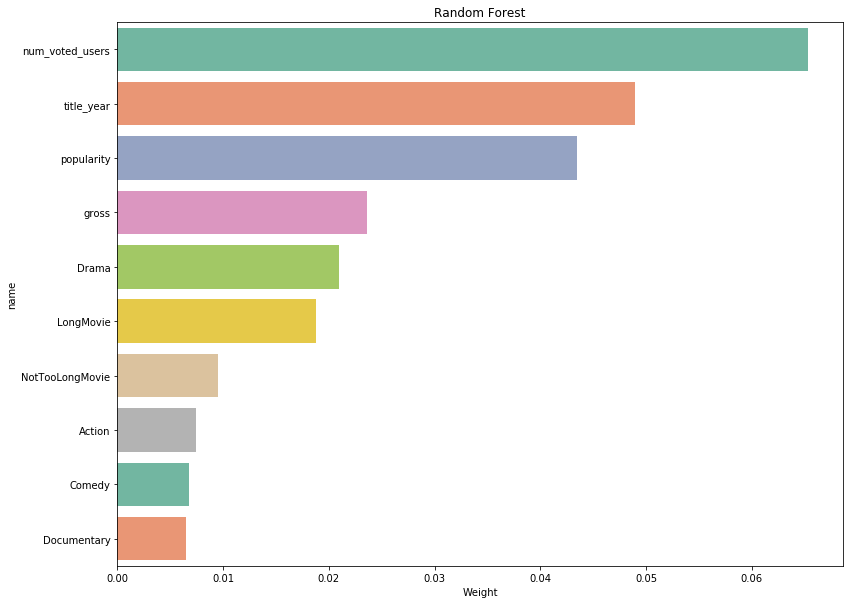

In [96]:
g = sns.barplot(0,"name",data = rf_fea.sort_values(by=0, ascending=False)[0:10], palette="Set2",orient = "h")
g.set_xlabel("Weight")
g = g.set_title("Random Forest")

In [97]:
gb_fea = pd.DataFrame(gb.feature_importances_)
gb_fea["name"] = list(X_train) 
gb_fea.sort_values(by=0, ascending=False).head()

,0,name
2,0.148473,num_voted_users
3,0.091367,title_year
0,0.051178,popularity
1,0.036698,gross
17,0.036604,Drama


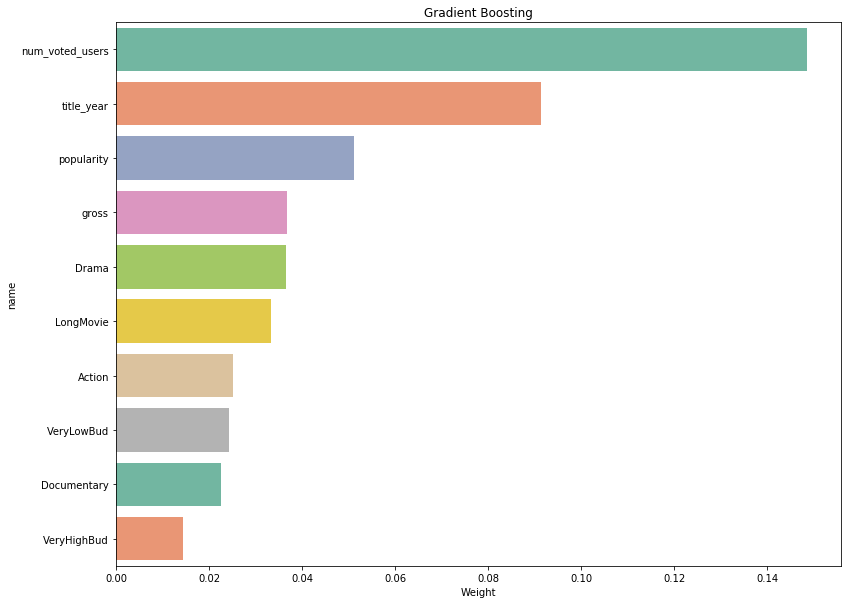

In [98]:
g = sns.barplot(0,"name",data = gb_fea.sort_values(by=0, ascending=False)[0:10], palette="Set2",orient = "h")
g.set_xlabel("Weight")
g = g.set_title("Gradient Boosting")

# Ensemble Learning (Voting)

In [99]:
voting = pd.DataFrame()

In [100]:
voting["knn"] =knn_result['Predict']
voting["GB"] = gb_result['Predict']
voting["RF"] = Rf_result['Predict']
voting['sum'] = voting.sum(axis=1)

voting['Predict'] = voting['sum'].map(lambda s: 1 if s >= 2 else 0)

voting['testAnswer'] = pd.DataFrame(test_result)

voting['Correct'] = np.where((voting['Predict'] == voting['testAnswer']) , 1, 0)

In [101]:
voting.head()

,knn,GB,RF,sum,Predict,testAnswer,Correct
0,0,1,1,2,1,0,0
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,1,0,1,0,0,1
4,0,0,0,0,0,0,1


In [102]:
voting['Correct'].mean()

0.7977126518942101

In [103]:
print(confusion_matrix(voting['testAnswer'], voting['Predict']))

[[1051   16]
 [ 267   65]]


In [104]:
print(classification_report(voting['testAnswer'], voting['Predict']))

             precision    recall  f1-score   support

          0       0.80      0.99      0.88      1067
          1       0.80      0.20      0.31       332

avg / total       0.80      0.80      0.75      1399

